In [1]:
import pandas as pd
import seaborn as sns

In [4]:
orders = pd.read_csv('./Data/orders.csv')
orderlines = pd.read_csv('./Data/orderlines.csv')
products = pd.read_csv('./Data/products.csv')
brands = pd.read_csv('./Data/brands.csv')

### Orders

In [5]:
orders = orders.loc[~orders.total_paid.isna(), :]
orders["created_date"] = pd.to_datetime(orders["created_date"])

In [6]:
orders_trim = orders.loc[orders.order_id.isin(orderlines.id_order)]
orders_trim = orders_trim.loc[orders_trim.state == 'Completed']
orders_trim = orders_trim.loc[~(orders_trim.total_paid <= 0)]
orders_trim['created_date'] = pd.to_datetime(orders_trim.created_date)

In [7]:
orders_trim.to_csv("./Data/orders_cleaned.csv", index=False)

### Products
1. Price and Promo Price should both be integers, but instead appear as text
2. In stock looks like Integer, but is thought out like Bool
3. What the what is Type supposed to mean?

In [ ]:
products.drop_duplicates(inplace=True)
products.loc[products.desc.isna(), 'desc'] = products.loc[products.desc.isna(), 'name']
products.loc[products.type.isna(), 'type'] = 'missing'
products = products.drop(columns='promo_price')

In [ ]:
# First toss out items with no Products price
no_price = products.loc[products.price.isna()]['price']
products = products.loc[~products.price.isin(no_price)].reset_index(drop=True)

In [ ]:
# First get SKUs of products with bad prices, then get SKUs of those products which were actually ordered
# This way there's a sales price to compare to the Products price
double_dot_skus = products.loc[products.price.str.contains('\d+\.\d+\.'), 'sku']
ordered_double_dot_skus = orderlines.loc[orderlines.sku.isin(double_dot_skus)]

In [ ]:
# Merge to compare bad prices to unit prices as sold
compare = pd.merge(ordered_double_dot_skus, products, on='sku')
# Toss out corrupted unit prices
compare = compare.loc[~compare.unit_price.str.contains('\d\.\d+\.\d+')]
compare['unit_price'] = pd.to_numeric(compare.unit_price)

In [ ]:
# Find average unit price according to sales as metric
comp_avg = compare.groupby('sku')[['price', 'unit_price']].mean()
comp_avg.rename(columns={'unit_price':'avg_unit_price'}, inplace=True)

In [ ]:
# Compare unit price metric to corrupted prices
compare = pd.merge(compare, comp_avg, on='sku')

In [ ]:
# Remove first dot and step the price down by one order of magnitude until parity achieved
def prod_price_cleaner2(price, unit_price):
  price = price.replace('.', '', 1)
  price = float(price)
  if unit_price == 0:
    return 0
  while unit_price / price < 0.14:
    price /= 10
  return round(price, 2)

In [ ]:
compare['clean_price'] = compare.apply(lambda x: prod_price_cleaner2(x['price'], x['avg_unit_price']), axis=1)

In [ ]:
# Average new parity-matched prices across SKUs
clean_skus = compare.groupby('sku').clean_price.mean()
products = pd.merge(products, clean_skus, on='sku', how='left')

In [ ]:
# Apply SKU-averaged prices to corrupted prices
products['price'] = pd.to_numeric(products.price, errors='coerce')
products['price'] = products.apply(lambda x: x['clean_price'] if x['clean_price'] > 0 else x['price'], axis=1)
# Toss out unrecoverable data lines
products = products.loc[~products.price.isna()]
products['price'] = products.price.apply(lambda x: round(x, 2))
products.drop(columns='clean_price', inplace=True)

In [ ]:
# Bin prices for later use in orderlines
products['clean_judge'] = products.price.apply(lambda x: 'low' if x < 100 else 'high')
big = products.loc[products.clean_judge == 'high', 'sku']
little = products.loc[products.clean_judge == 'low', 'sku']

### Categories:
* PCs, Laptops, Servers & Harddrives
* iPhone, iPad, iPod, Apple Watch
* Cables & Adaptors
* Parts and Repair
* Accessories & Memory

In [ ]:
from collections import Counter
types = list(products.type.unique())
type_dict = {}
for t in types:
  type_dict[t] = list(products.loc[products.type == t, 'desc'])

In [ ]:
type_words = {}
for td in type_dict.keys():
  string = ''
  for value in type_dict[td]:
    string += ' '+ value.lower()
    words_list = string.split()
    new_list = []
    for l in words_list:
      l = l.replace('.','').replace('+', '/').replace('/','')
      new_list.append(l)
    for item in new_list:
      if item in ['', ' ', 'your', 'and', 'with', 'for', 'of', 'to', '|', 'or']:
        new_list.remove(item)
    counter = Counter(new_list)
    most_occur = counter.most_common(5)
    words = []
    for i in range(len(most_occur)):
      words.append(most_occur[i][0])
    type_words[td] = words


In [ ]:
keys = ['Accessories & Memory', 'Cables & Adaptors', 'Parts, Repair, & Warranties', 'PCs, Laptops, Servers & Harddrives', 'iPhone, iPad, iPod, Apple Watch', 'Unknown']
categories = {key: [] for key in keys}

In [ ]:
for tw in type_words:
  for item in ['support', 'stand', 'keyboard', 'mouse', 'headphone', 'case', 'Case', 'headset', 'Wacom', 'tips', 'card', 'backpack', 'microphone', 'Remote', 'player', 'DVD', 
                'two-wheeled', 'speaker', 'pen', 'armband', 'external', 'Pen', 'Flash']:
                if item.lower() in type_words[tw]:
                  categories['Accessories & Memory'].append(tw)
                  break
  else:  
    for item in ['Lightning', 'cable', 'Cable', 'Thunderbolt', 'Ethernet', 'Charger', 'charger', 'connector', 'adaptor','adapter', 'SATA', 'outlets', 'HomeKit', 'router']:
                if item.lower() in type_words[tw]:
                  categories['Cables & Adaptors'].append(tw) 
                  break
    else:  
      for item in ['parts', ' repair', 'diagnosis', 'extended', 'Protector', 'Cleaner', 'Replacement', 'replacement']:
                if item.lower() in type_words[tw]:
                  categories['Parts, Repair, & Warranties'].append(tw)
                  break
      else:
        for item in ['Synology', 'SSD', 'MacBook', 'PC', 'iMac', 'Computer', 'computer', 'Mac', 'Expansion', 'Core']:
                if item.lower() in type_words[tw]:
                  categories['PCs, Laptops, Servers & Harddrives'].append(tw)
                  break

        else:
          for item in ['iPhone', 'iPad', 'Watch', 'iPod']:
                if item.lower() in type_words[tw]:
                  categories['iPhone, iPad, iPod, Apple Watch'].append(tw)
                  break
          else:
            categories['Unknown'].append(tw)

In [ ]:
def cat_app(thing):
  answer = ''
  for cat in categories.keys():
    if thing in categories[cat]:
      answer = cat
  if answer == '':
    print('Error')
    return 'Error'
  return answer

In [ ]:
products['categories'] = products.type.apply(cat_app)

In [ ]:
products.to_csv("./Data/products_categorized.csv", index=False)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Order lines
1. Unit price is a string
2. Does date need work?
3. There's an order of 999 items

In [ ]:
orderlines["date"] = pd.to_datetime(orderlines["date"])

In [ ]:
bad_batch = orderlines.loc[orderlines.unit_price.str.contains("\d+\.\d+\.\d+")].copy()

In [ ]:
new = orderlines[~orderlines.unit_price.str.contains('\d+\.\d+\.\d+')].copy()
new['unit_price'] = pd.to_numeric(new['unit_price'])
high_low = new.groupby('sku').mean()['unit_price'].reset_index()

In [ ]:
high_low2 = high_low.loc[high_low.sku.isin(bad_batch['sku'])]
high_low2['up_down'] = high_low2.unit_price.apply(lambda x: 'high' if x > 100 else 'low')
high2 = high_low2.loc[high_low2.up_down == 'high', 'sku']
low2 = high_low2.loc[high_low2.up_down == 'low', 'sku']
low2 = list(low2)
high2 = list(high2)

<ipython-input-236-5aa6ac4d7411>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  high_low2['up_down'] = high_low2.unit_price.apply(lambda x: 'high' if x > 100 else 'low')


In [ ]:
def ol_price_cleaner2(price, sku):
  if sku in high2:
    price = price.replace('.','',1)
    return round(float(price), 2)
    # return price
  if sku in low2:
    price = price[-4:]
    return float(''.join(price))
    # return '.'.join(price)
  if sku in big:
    price = price.replace('.','',1)
    return round(float(price), 2)
  if sku in little:
    price = price.replace('.','',1)
    return round(float(price)/100, 2)
  else:
    return price

In [ ]:
orderlines_trim = orderlines.loc[orderlines.id_order.isin(orders_trim.order_id)]
orderlines_trim['price_clean'] = orderlines_trim.loc[orderlines_trim.unit_price.str.contains('\d+\.\d+\.\d+')].apply(lambda x: ol_price_cleaner2(x['unit_price'], x['sku']), axis=1)
orderlines_trim['price_clean'] = pd.to_numeric(orderlines_trim['price_clean'], errors='coerce')
orderlines_trim['unit_price'] = orderlines_trim.apply(lambda x: x['price_clean'] if x['price_clean'] > 0 else x['unit_price'], axis=1)
orderlines_trim['unit_price'] = pd.to_numeric(orderlines_trim['unit_price'], errors='coerce')
orderlines_trim = orderlines_trim.loc[orderlines_trim.sku.isin(products.sku)]

In [ ]:
orderlines_trim = orderlines_trim.loc[~orderlines_trim.unit_price.isna()]

In [ ]:
orderlines_trim.rename(columns={'id_order':'order_id'}, inplace=True)

In [ ]:
orderlines_trim.to_csv("./Data/orderlines_cleaned.csv", index=False)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Experiments

Short analysis on the two-dot prices:
Looks like there's two things going on. One is cheap prices where two have been shoved together.
2.976.59 being 2.97 and 6.59
The other is high prices where a "." comes in to indicate a thousands column.
1.120.99 being 1120.99 (which can be written 1,120.99 for readability)
Took some manual investigation, but I think we can make a function to sort cases based on average price and adjust appropriately.

Select for right-side price on lows.

### Discounts

* Is more sold when more discounts are available?
  -  No, but discount stability appears important
* Do higher discounts encourage higher sales?
  - Not entirely: higher priced items need only a 10% discount or so, cheap items sell best with high discounts.
* Are there items that only sell with discount?
  - The vast majority sell only with discounts

In [ ]:
products_cl = pd.read_csv("./Data/products_categorized.csv")
orders_cl = pd.read_csv("./Data/orders_cleaned.csv")
orderlines_cl = pd.read_csv("./Data/orderlines_cleaned.csv")

In [ ]:
# orderlines_cl.rename(columns={'id_order':'order_id'}, inplace=True)
orderlines_cl['date'] = pd.to_datetime(orderlines_cl.date)
orders_cl['created_date'] = pd.to_datetime(orders_cl.created_date)
discounts = pd.merge(orderlines_cl, orders_cl, on='order_id', how='inner')
discounts.drop(columns=['product_id', 'price_clean', 'created_date'], inplace=True)
pro_price = products_cl[['sku', 'price', 'categories']]
discounts = pd.merge(discounts, pro_price, on='sku')
discounts.rename(columns={'price':'full_price'}, inplace=True)

In [ ]:
discounts['full_price'] = round(discounts.full_price, 2)
discounts['unit_price_total'] = discounts.unit_price * discounts.product_quantity
discounts['discount'] = 1 - discounts.unit_price / discounts.full_price
discounts['totals_diff'] = discounts.total_paid - discounts.unit_price_total
# discounts = discounts.loc[discounts.totals_diff > -50]

In [ ]:
discounts.discount.describe(), discounts.totals_diff.describe()

(count    59830.000000
 mean         0.225836
 std          0.207078
 min         -2.122653
 25%          0.089648
 50%          0.179198
 75%          0.296030
 max          0.999960
 Name: discount, dtype: float64, count    59830.000000
 mean       182.053006
 std        576.208860
 min       -165.000000
 25%          3.990000
 50%          6.990000
 75%         81.977500
 max      10583.380000
 Name: totals_diff, dtype: float64)

In [ ]:
discounts = discounts.loc[discounts.totals_diff <= (81.98 + 1.5*(81.98-3.99))]
discounts = discounts.loc[discounts.totals_diff >= (3.99 - 1.5*(81.98-3.99))]
discounts = discounts.loc[discounts.discount <= (0.296 + 1.5*(0.296-0.09))]
discounts = discounts.loc[discounts.discount <= (0.9 - 1.5*(0.296-0.09))]

In [ ]:
discounts['price_cats'] = pd.cut(discounts.full_price, bins=(0, 39.95, 89.95, 204.99, 2600), labels=['cheap', 'mid-price', 'high-price', 'premium'])
discounts['discount_cats'] = pd.cut(discounts.discount, bins=(-0.5, 0, 0.05, 0.176, 1), labels=['oversold','low','middle','high'])

In [ ]:
discounts['regime'] = discounts.discount.apply(lambda x: 'full' if (x <= 0.000000001) else 'discount')

In [ ]:
weekly_full = discounts.loc[discounts.regime == 'full'].resample('W', on='date').id.count().reset_index()
weekly_disc = discounts.loc[discounts.regime == 'discount'].resample('W', on='date').id.count().reset_index()
weekly_items = pd.merge(weekly_full, weekly_disc, on='date')
weekly_items.rename(columns={'id_x':'full_price', 'id_y':'discount'}, inplace=True)
weekly_items['date'] = weekly_items.date.dt.strftime('%y%W')
weekly_items['date'] = pd.to_numeric(weekly_items.date)
weekly_items.set_index('date')
weekly_items['total'] = weekly_items.full_price + weekly_items.discount
weekly_items['full_prop'] = weekly_items.apply(lambda x: x['full_price'] / x['total'], axis=1)
weekly_items['disc_prop'] = weekly_items.apply(lambda x: x['discount'] / x['total'], axis=1)


In [ ]:
weekly_props = weekly_items[['full_prop', 'disc_prop']]
weekly_props

,full_prop,disc_prop
0,0.081967,0.918033
1,0.133641,0.866359
2,0.097750,0.902250
3,0.092093,0.907907
4,0.070342,0.929658
...,...,...
59,0.075935,0.924065
60,0.094415,0.905585
61,0.071505,0.928495
62,0.086008,0.913992


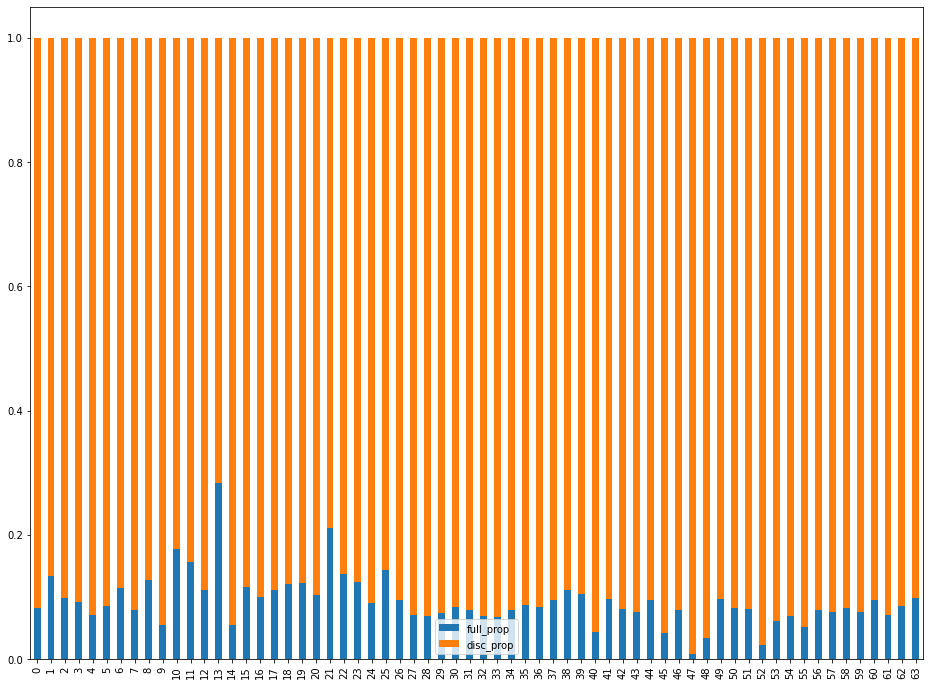

In [ ]:
#This is reference code. The guide is at
# https://towardsdatascience.com/100-stacked-charts-in-python-6ca3e1962d2b

# cross_tab_prop.plot(kind='bar', 
#                     stacked=True, 
#                     colormap='tab10', 
#                     figsize=(10, 6))

# plt.legend(loc="upper left", ncol=2)
# plt.xlabel("Release Year")
# plt.ylabel("Proportion")
# plt.show()

weekly_props.plot(kind='bar',
                  stacked=True,
                  figsize=(16,12))

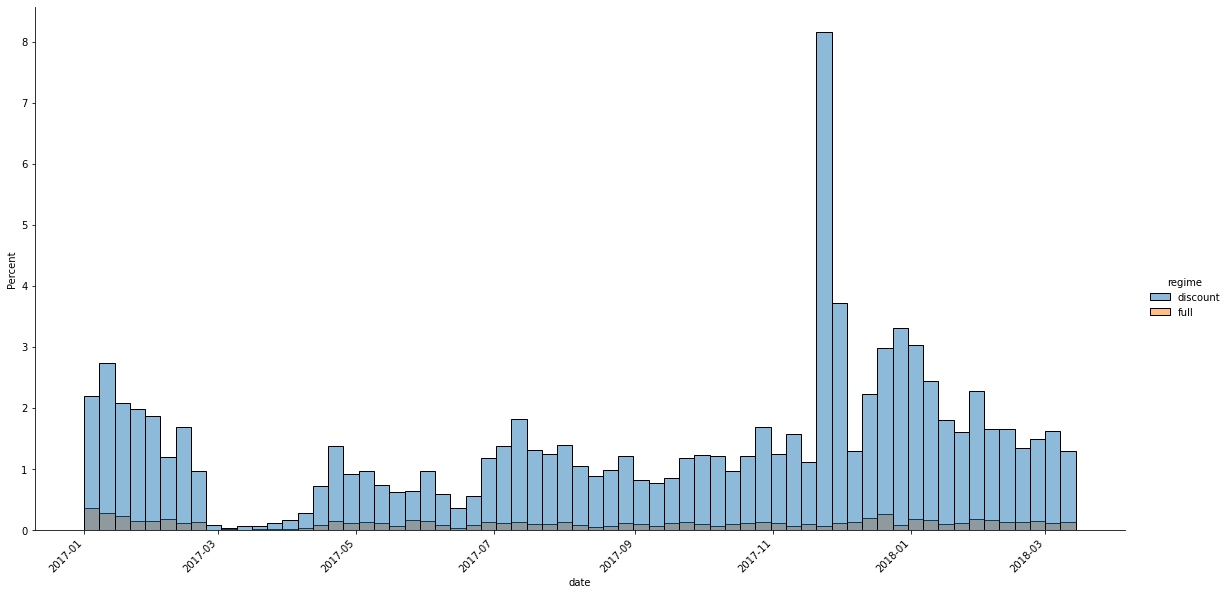

In [ ]:
ax = sns.displot(data=discounts,
             x='date',
             hue='regime',
             height=8,
             aspect=2,
             kind='hist',
             stat = 'percent',
             bins=65
             )
ax.set_xticklabels(rotation = 45, ha = 'right');

In [ ]:
full_sales = (
    discounts.loc[discounts.discount <= 0.000000001]
    .resample('D', on='date').unit_price_total.sum().reset_index()
    )
full_sales['discount'] = 0
full_sales['regime'] = 'full'

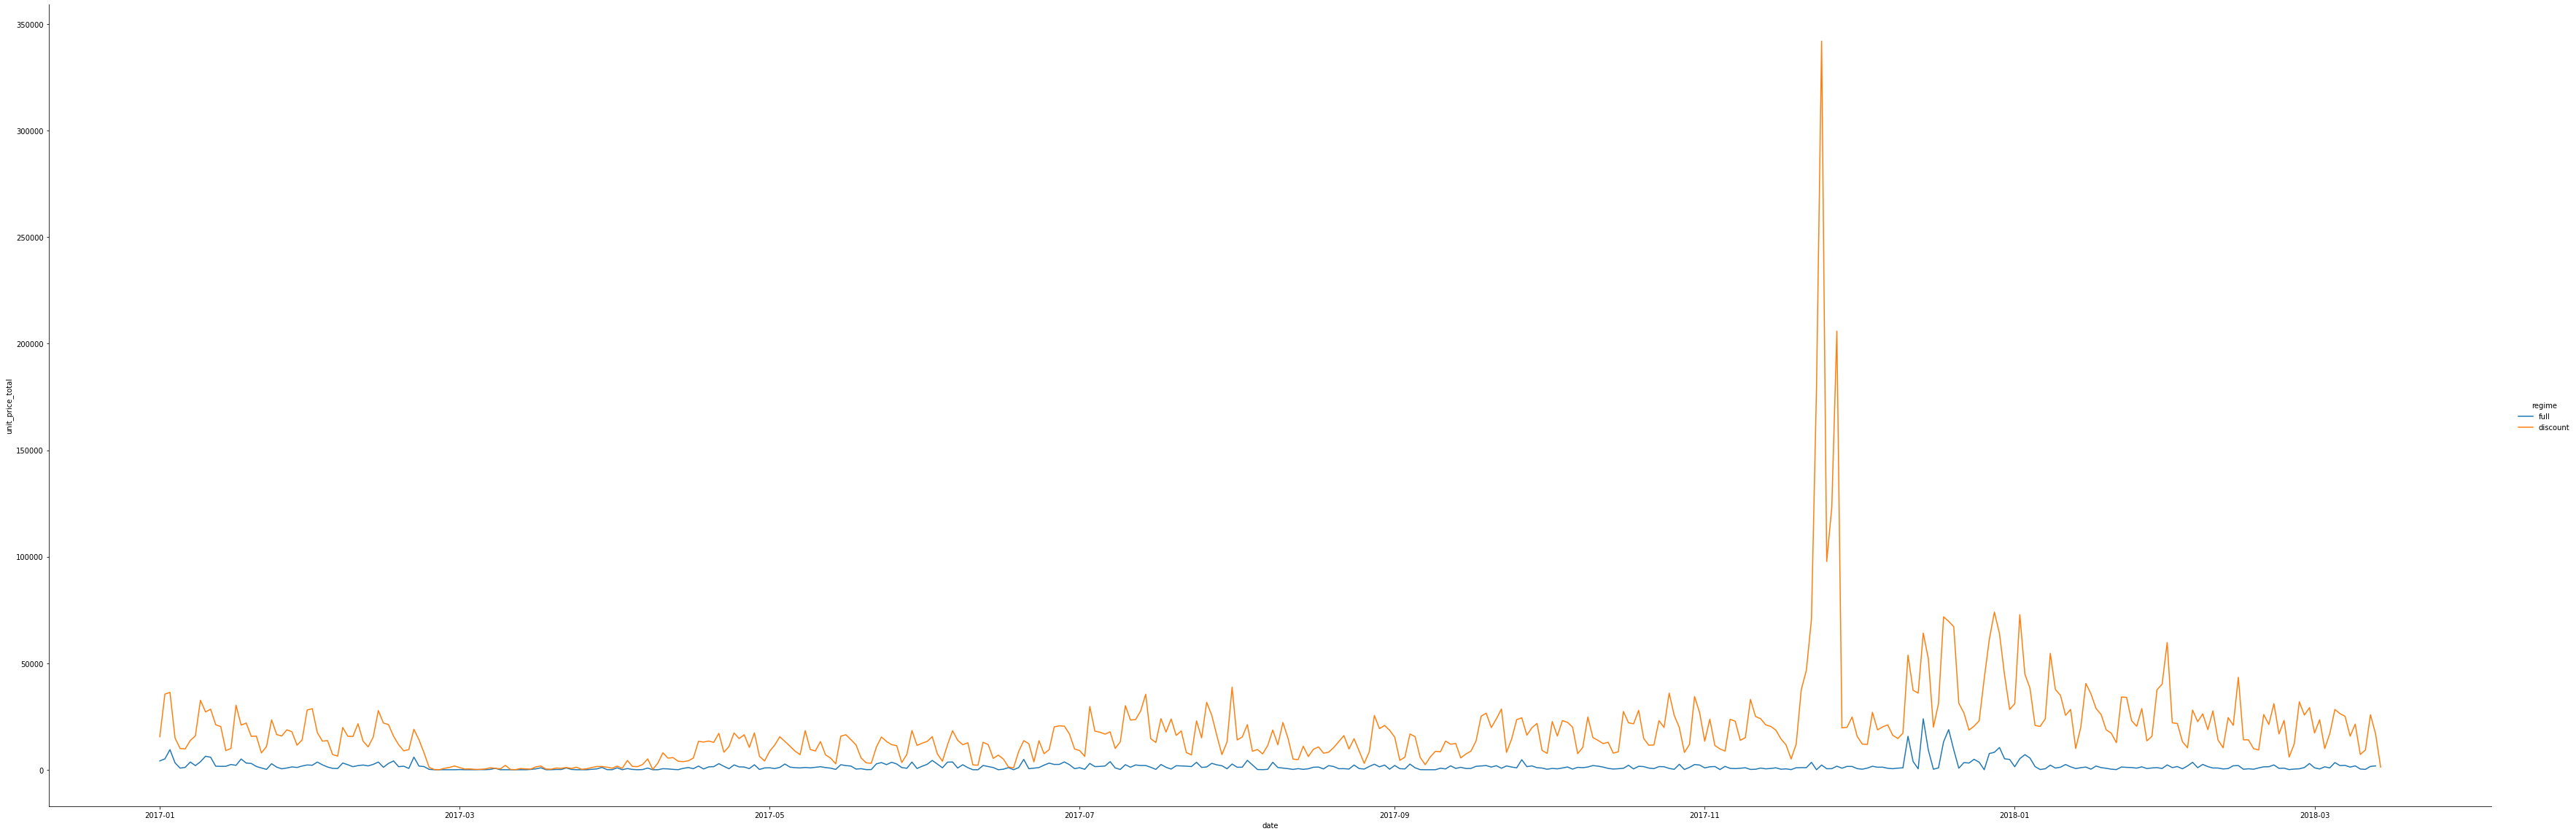

In [ ]:
rev_avg_disc_daily = discounts.resample('D', on='date').agg({'unit_price_total':'sum', 'discount':'mean'}).reset_index()
rev_avg_disc_daily['regime'] = 'discount'
rev_comp = pd.concat([full_sales, rev_avg_disc_daily]).reset_index()

sns.relplot(data=rev_comp,
            x='date',
            y='unit_price_total',
            kind='line',
            aspect=3,
            height=16,
            hue='regime'
            );

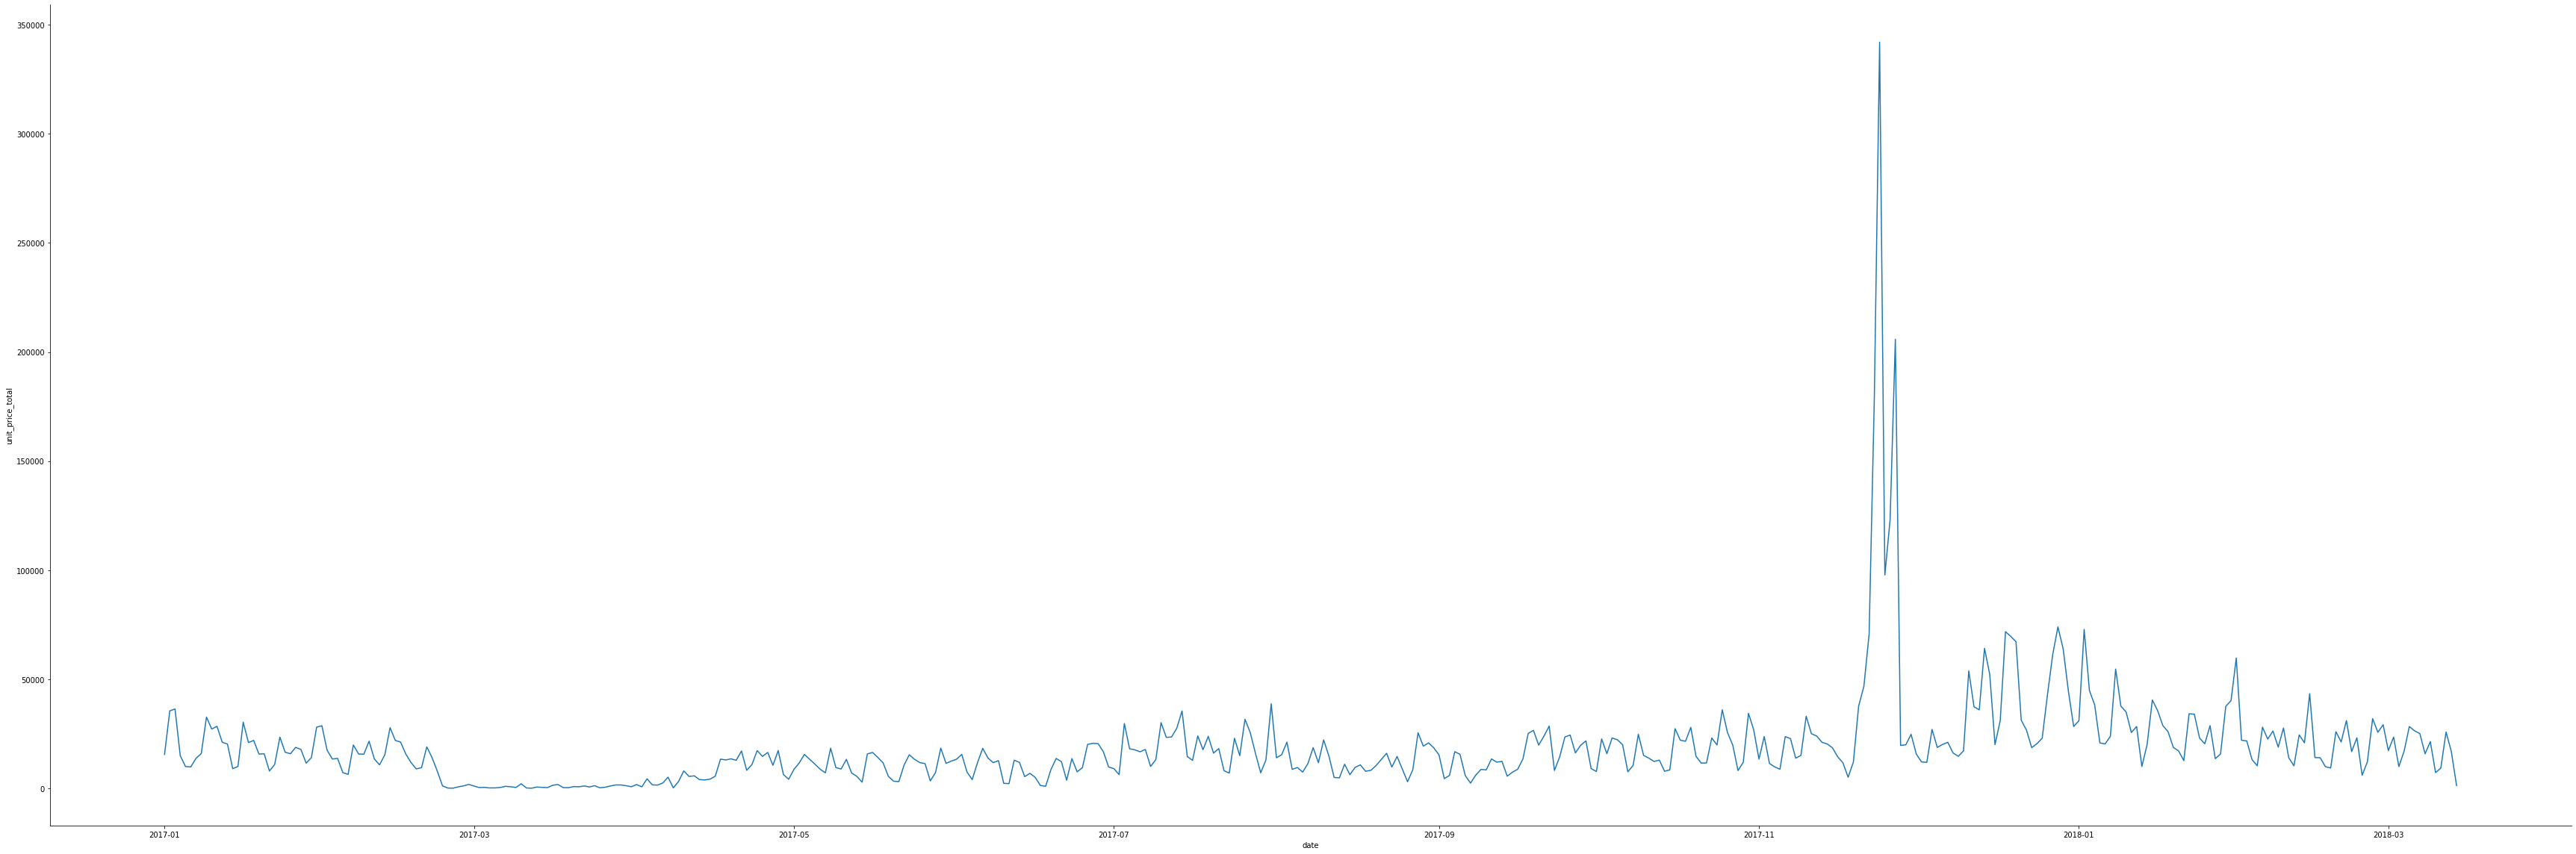

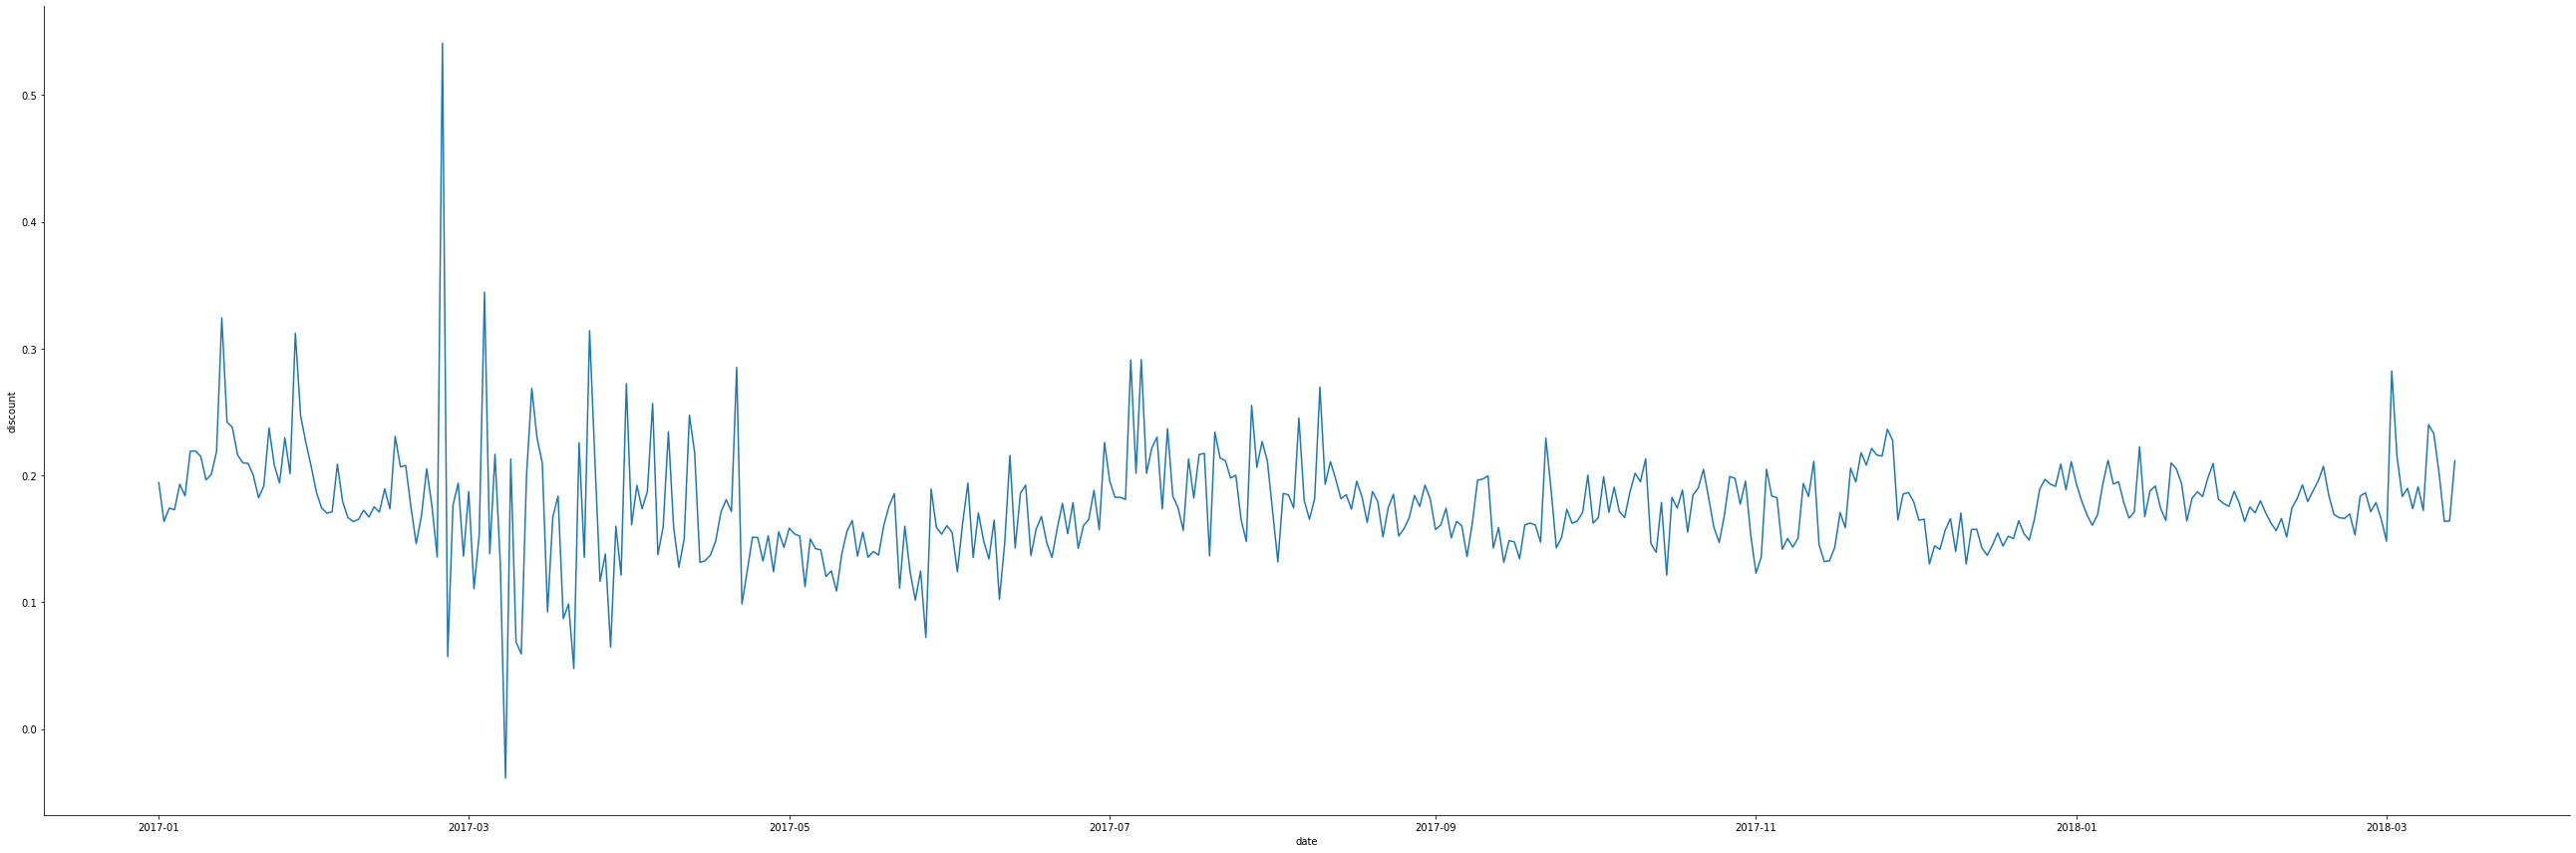

In [ ]:
sns.relplot(data=rev_avg_disc_daily,
            x='date',
            y='unit_price_total',
            kind='line',
            aspect=3,
            height=16
            );
sns.relplot(data=rev_avg_disc_daily,
            x='date',
            y='discount',
            kind='line',
            aspect=3,
            height=12
            );

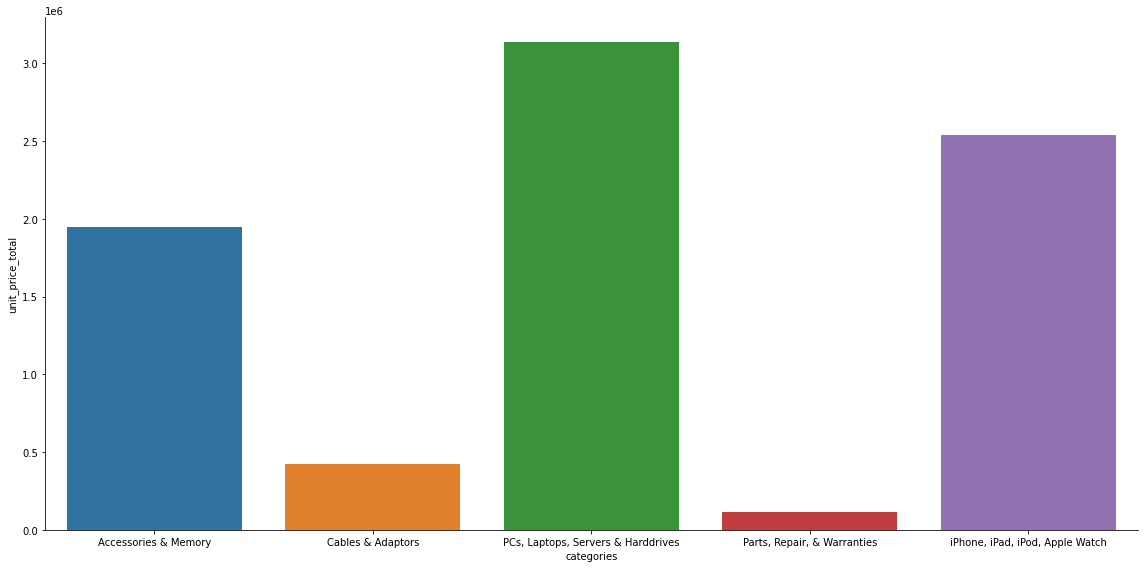

In [ ]:
cat_sales = discounts.groupby('categories').unit_price_total.sum().reset_index()

sns.catplot(data=cat_sales,
            kind='bar',
            x='categories',
            y='unit_price_total',
            aspect=2,
            height=8
            );

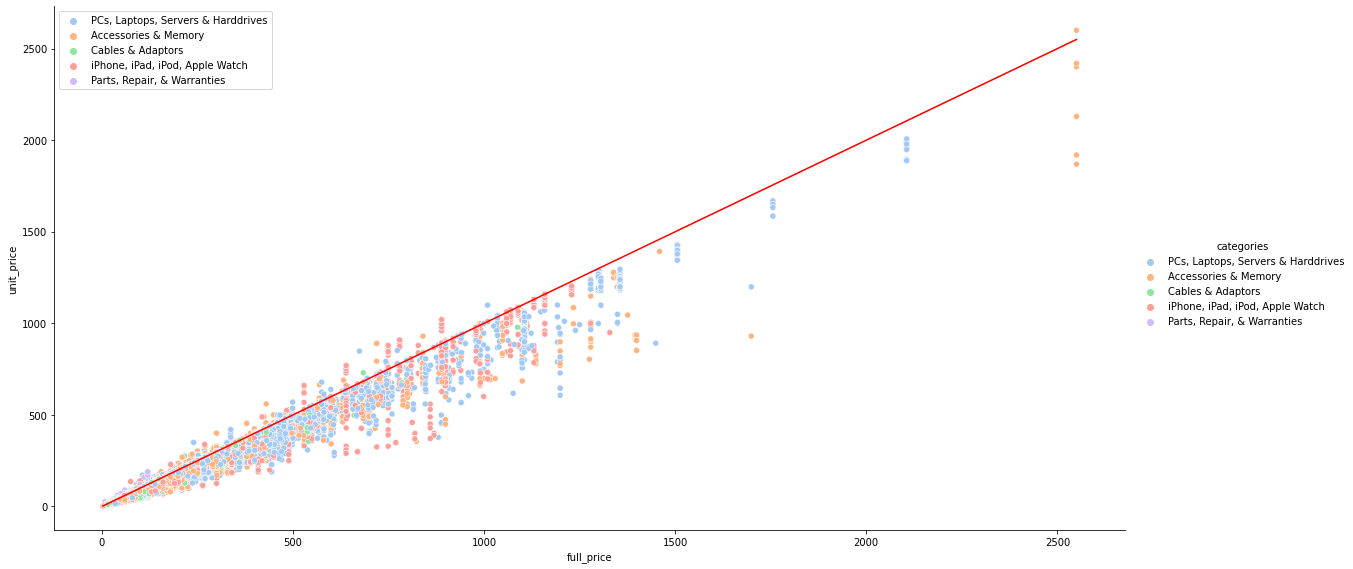

In [ ]:
# Somewhere around 1000€ nothing sells for full price
# discounts['90_ref'] = discounts.full_price.apply(lambda x: x*0.9)
# discounts['80_ref'] = discounts.full_price.apply(lambda x: x*0.8)
# discounts['70_ref'] = discounts.full_price.apply(lambda x: x*0.7)


sns.relplot(data=discounts, 
            x="full_price",
            y='unit_price',
            height=8,
            aspect=2,
            hue='categories',
            palette='pastel')
sns.lineplot(data=discounts,
             x='full_price',
             y='full_price',
             color='red');
# sns.lineplot(data=discounts,
#              x='full_price',
#              y='90_ref',
#              color='green')
# sns.lineplot(data=discounts,
#              x='full_price',
#              y='80_ref',
#              color='yellow');

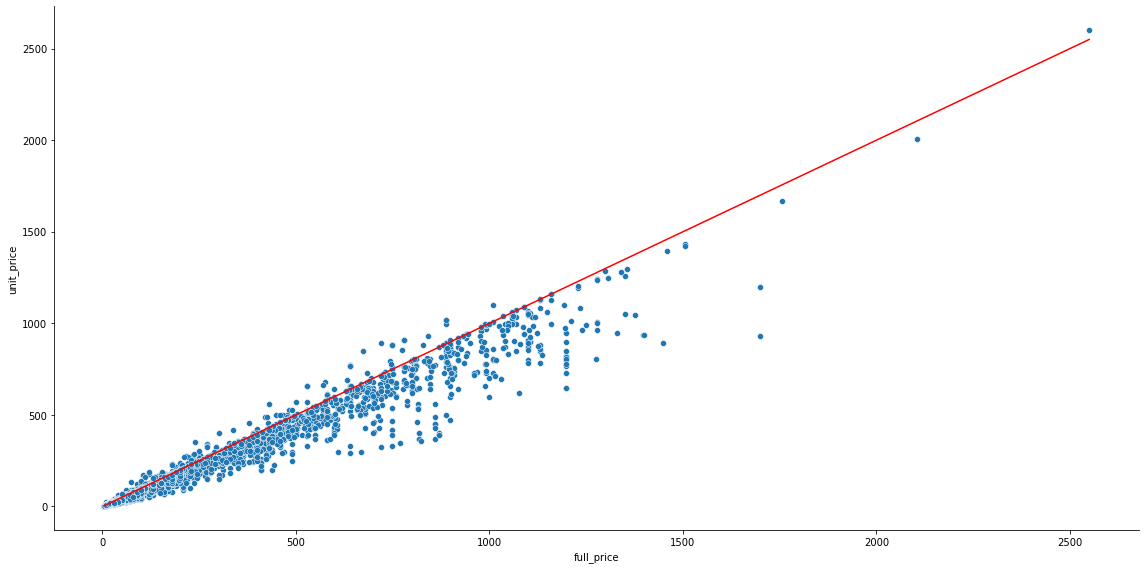

In [ ]:
# Are there items that only sell with discount?
# discounts.loc[discounts.discount <= 0.0000000001]
max_sales_price = discounts.groupby('sku', as_index=False).agg({'unit_price':'max', 'full_price':'first'})
max_sales_price.loc[max_sales_price.unit_price < max_sales_price.full_price]

sns.relplot(data= max_sales_price,
            x='full_price',
            y='unit_price',
            height=8,
            aspect=2)
sns.lineplot(data= max_sales_price,
             x='full_price',
             y='full_price',
             color='red');

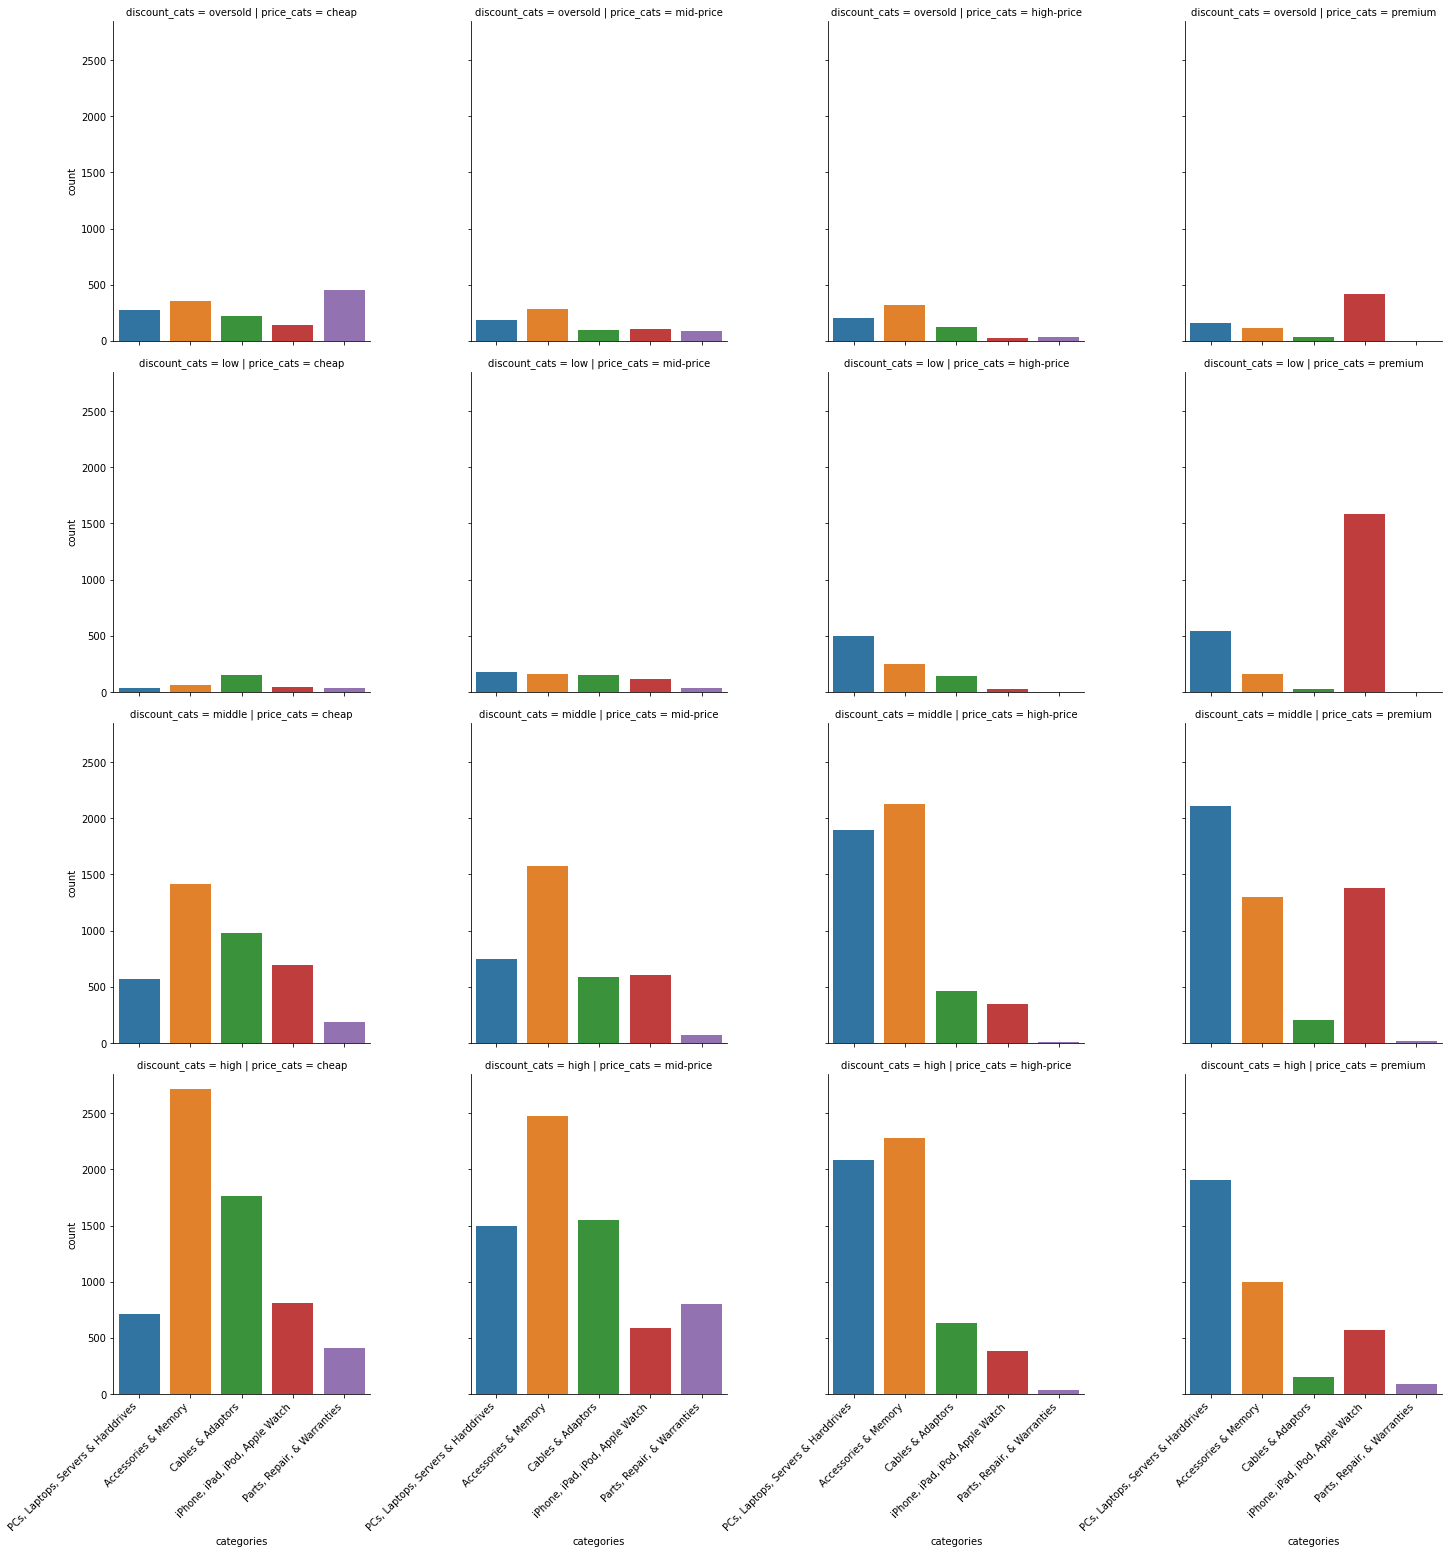

In [ ]:
ax = sns.catplot(data=discounts,
            x='categories',
            col='price_cats',
            row='discount_cats',
            # hue='categories',
            kind='count'
            # orient='v'
            )

ax.set_xticklabels(rotation = 45, ha = 'right');

In [ ]:
products_cl.groupby('categories').agg(min_price=('price','min'), max_price=('price', 'max'), mean_price=('price', 'mean'))

,min_price,max_price,mean_price
categories,,,
Accessories & Memory,3.49,11129.00,438.654619
Cables & Adaptors,3.99,1881.99,93.552819
"PCs, Laptops, Servers & Harddrives",3.99,15339.00,1144.257287
"Parts, Repair, & Warranties",2.99,899.90,105.967818
"iPhone, iPad, iPod, Apple Watch",2.99,3059.99,385.886459
